# Morans I analysis

In [1]:
%matplotlib inline

import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
import contextily as ctx
import gtfs_kit as gk
import shapely
import rtree
import xarray as xr
from shapely.geometry import mapping
from shapely.ops import unary_union
import h3
import base64
import urllib
import tempfile
import networkx as nx
from csv import DictReader
from itertools import groupby
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation, plot_moran
)
from splot.libpysal import plot_spatial_weights
from pysal.lib import weights
import esda
plot_moran

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


<function splot._viz_esda_mpl.plot_moran(moran, zstandard=True, aspect_equal=True, scatter_kwds=None, fitline_kwds=None, **kwargs)>

In [2]:
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels

# Morans I reagrding accesibility for the county

In [3]:
gdf = gpd.read_parquet("county_gdf.parquet")

In [4]:
gdf.shape

(3390, 111)

In [5]:
w_gdf = gdf.copy()

In [6]:
w_gdf["log_accessibility_score"] = np.log(w_gdf["accessibility_score"] + 1)

In [7]:
w = weights.Queen.from_dataframe(w_gdf, idVariable="GEOID")

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 36081091603, 36081107201.
  warnings.warn(message)


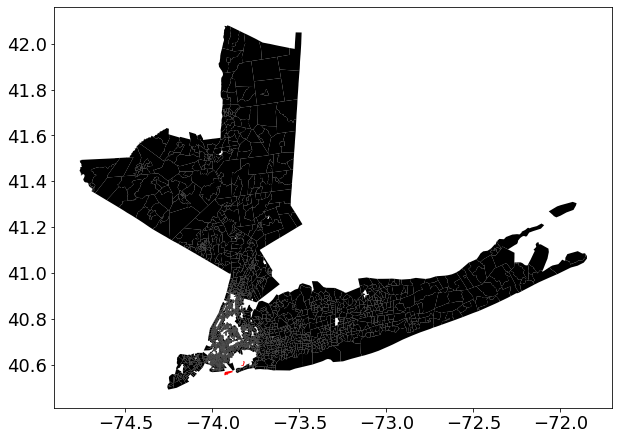

In [8]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax = w_gdf.loc[~w_gdf.GEOID.isin(w.islands), :].plot(color='black', ax=ax)
ax = w_gdf.loc[w_gdf.GEOID.isin(w.islands), :].plot(color='red', ax=ax)
plt.show()

In [9]:
w_gdf = w_gdf.loc[~w_gdf.GEOID.isin(w.islands), :].reset_index(drop=True)

In [10]:
%time w = weights.Queen.from_dataframe(w_gdf, idVariable="GEOID")

CPU times: user 1.75 s, sys: 54.8 ms, total: 1.81 s
Wall time: 1.82 s


In [11]:
target_variable = "log_accessibility_score"

In [12]:
lisa = esda.Moran_Local(w_gdf[target_variable], w)

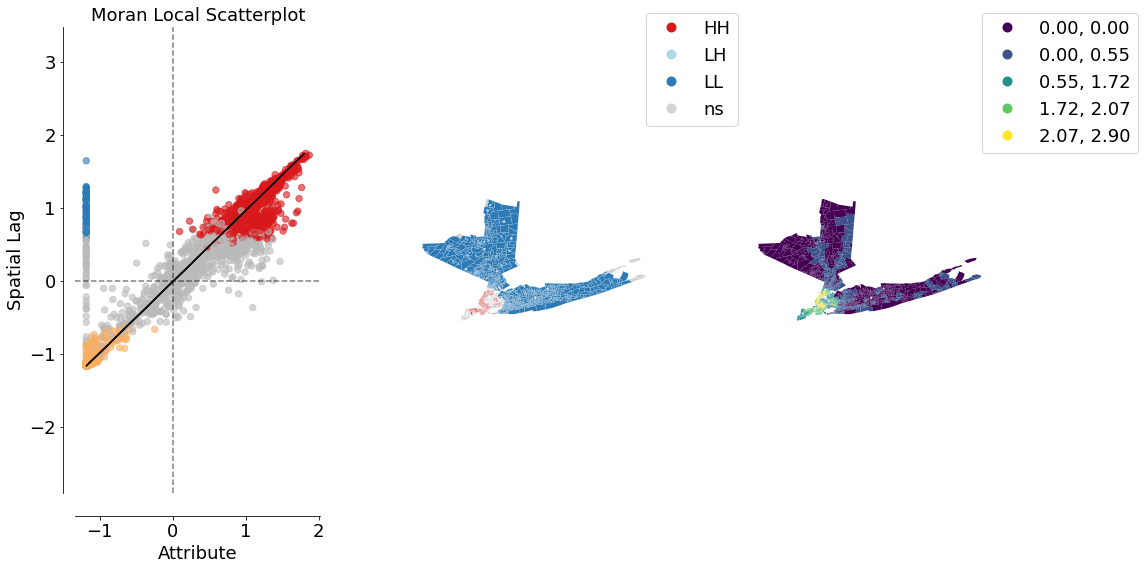

In [13]:


fig, axs = plot_local_autocorrelation(lisa, w_gdf, target_variable, figsize=(16,  8), cmap="viridis")
plt.tight_layout()
plt.savefig("figs/moransi_county_acc.png")

In [14]:
fig.legend(fontsize="medium")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [15]:
mi = esda.Moran(w_gdf[target_variable], w)
mi.I, mi.p_sim

(0.8659361715865385, 0.001)

(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.87', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.87)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

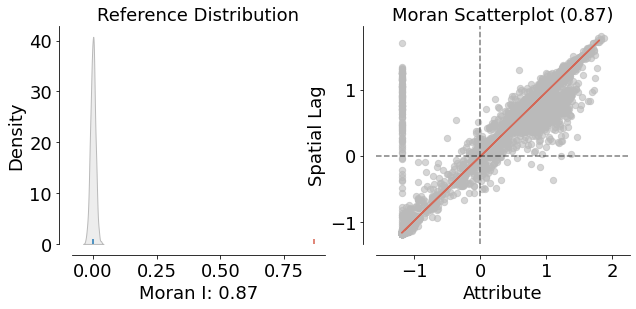

In [16]:
plot_moran(mi)

# Morans I reagrding puplictransportation for the county

In [17]:
gdf = gpd.read_parquet("county_gdf.parquet")

In [18]:
w_gdf = gdf.copy()

In [19]:
w_gdf.shape

(3390, 111)

In [20]:
w = weights.Queen.from_dataframe(w_gdf, idVariable="GEOID")

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 36081091603, 36081107201.
  warnings.warn(message)


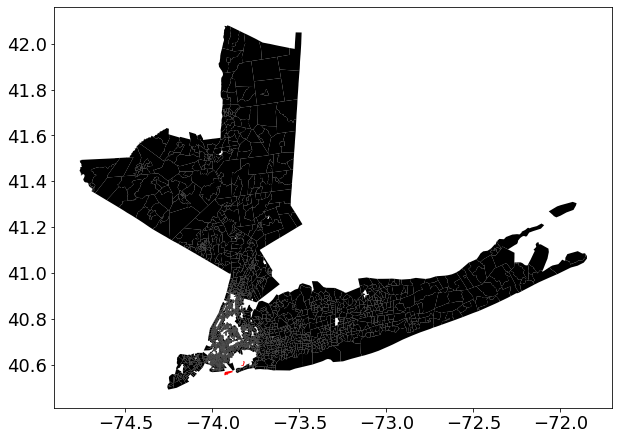

In [21]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax = w_gdf.loc[~w_gdf.GEOID.isin(w.islands), :].plot(color='black', ax=ax)
ax = w_gdf.loc[w_gdf.GEOID.isin(w.islands), :].plot(color='red', ax=ax)
plt.show()

In [22]:
w_gdf = w_gdf.loc[~w_gdf.GEOID.isin(w.islands), :].reset_index(drop=True)

In [23]:
%time w = weights.Queen.from_dataframe(w_gdf, idVariable="GEOID")

CPU times: user 1.71 s, sys: 45.7 ms, total: 1.75 s
Wall time: 1.76 s


In [24]:
target_variable = "over_16_puplictransportation"

In [25]:
lisa = esda.Moran_Local(w_gdf[target_variable], w)

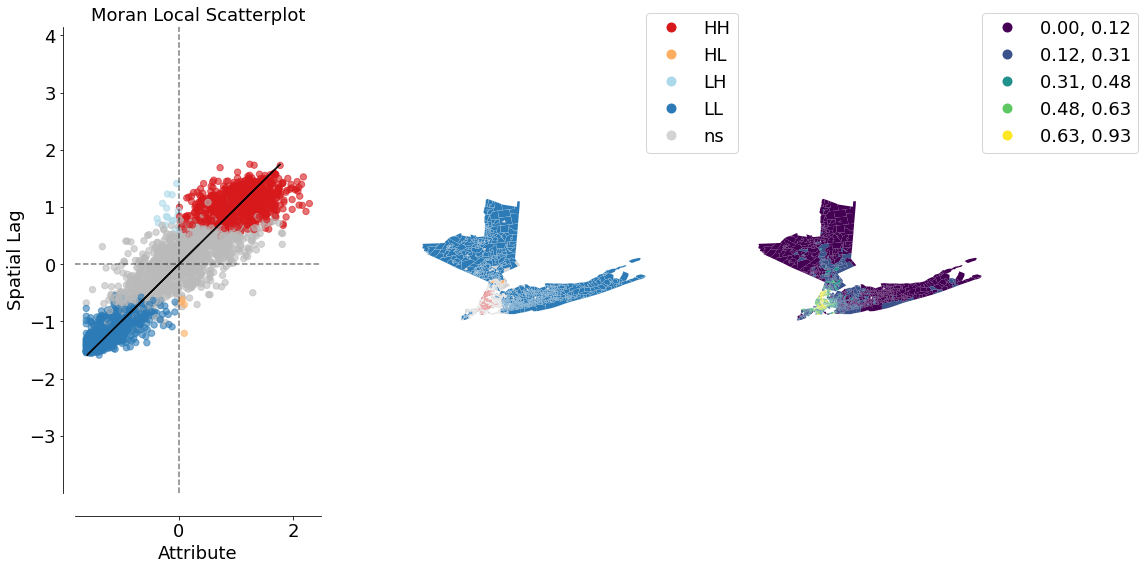

In [26]:
plot_local_autocorrelation(lisa, w_gdf, target_variable, figsize=(16,  8), cmap="viridis")
plt.tight_layout()
plt.savefig("figs/moransi_county_publ.png")

In [27]:
mi = esda.Moran(w_gdf[target_variable], w)
mi.I, mi.p_sim

(0.8880888256589684, 0.001)

(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.89', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.89)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

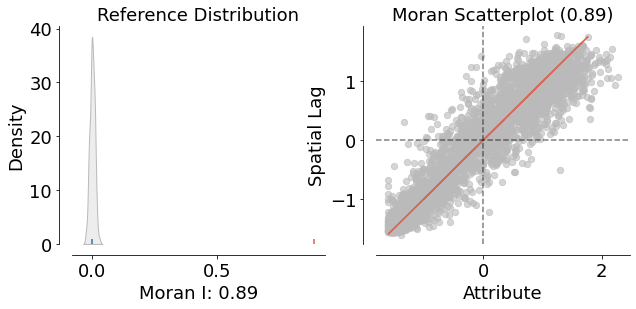

In [28]:
plot_moran(mi)

# Morans I reagrding accesibility for the city

In [29]:
gdf = gpd.read_parquet("city_gdf.parquet")

In [30]:
gdf.shape

(2216, 112)

In [31]:
w_gdf = gdf.copy()

In [32]:
w_gdf["log_accessibility_score"] = np.log(w_gdf["accessibility_score"] + 1)

In [33]:
w = weights.Queen.from_dataframe(w_gdf, idVariable="GEOID")

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 2 islands with ids: 36081091603, 36081107201.
  warnings.warn(message)


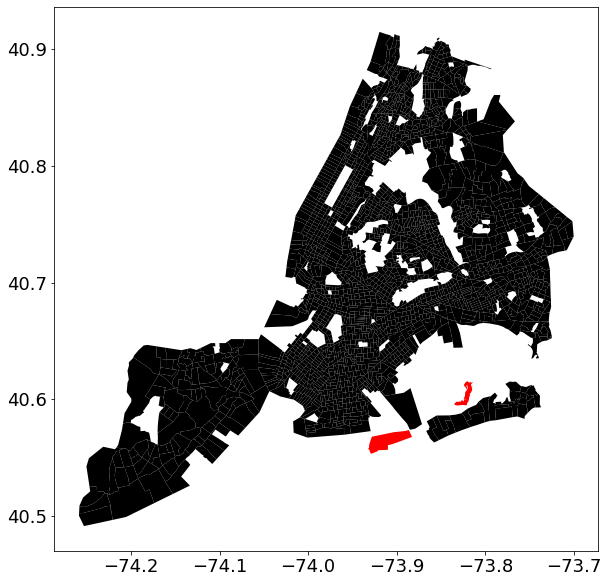

In [34]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax = w_gdf.loc[~w_gdf.GEOID.isin(w.islands), :].plot(color='black', ax=ax)
ax = w_gdf.loc[w_gdf.GEOID.isin(w.islands), :].plot(color='red', ax=ax)
plt.show()

In [35]:
w_gdf = w_gdf.loc[~w_gdf.GEOID.isin(w.islands), :].reset_index(drop=True)

In [36]:
%time w = weights.Queen.from_dataframe(w_gdf, idVariable="GEOID")

CPU times: user 591 ms, sys: 8.97 ms, total: 600 ms
Wall time: 599 ms


/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [37]:
target_variable = "log_accessibility_score"

In [38]:
lisa = esda.Moran_Local(w_gdf[target_variable], w)

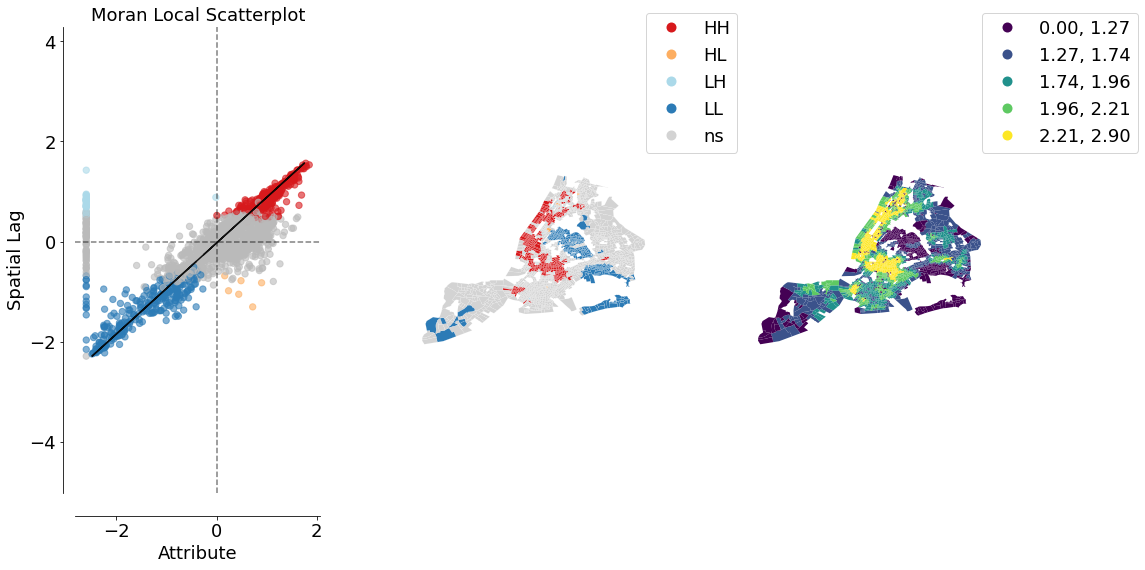

In [39]:
plot_local_autocorrelation(lisa, w_gdf, target_variable, figsize=(16,  8), cmap="viridis")
plt.tight_layout()
plt.savefig("figs/moransi_city_acc.png")

In [40]:
mi = esda.Moran(w_gdf[target_variable], w)
mi.I, mi.p_sim

(0.5527908114773882, 0.001)

(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.55', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.55)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

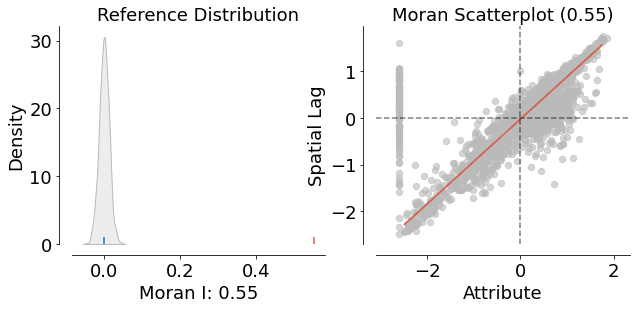

In [41]:
plot_moran(mi)

# Morans I reagrding puplictransportation for the city

In [42]:
gdf = gpd.read_parquet("city_gdf.parquet")

In [43]:
w_gdf = gdf.copy()

In [44]:
w_gdf.shape

(2216, 112)

In [45]:
w = weights.Queen.from_dataframe(w_gdf, idVariable="GEOID")

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 2 islands with ids: 36081091603, 36081107201.
  warnings.warn(message)


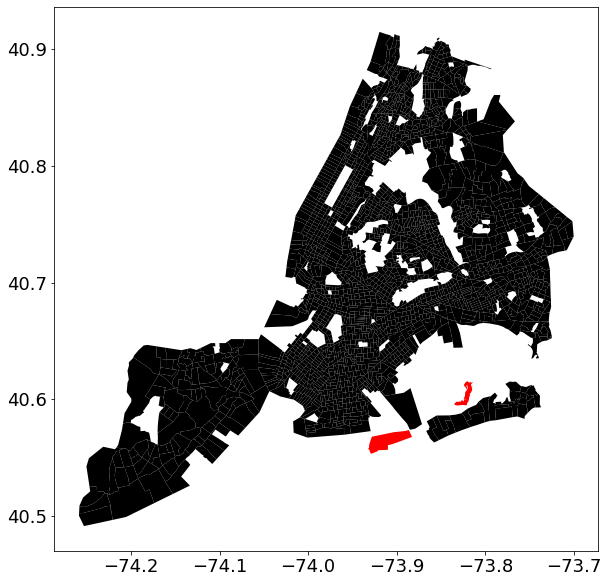

In [46]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax = w_gdf.loc[~w_gdf.GEOID.isin(w.islands), :].plot(color='black', ax=ax)
ax = w_gdf.loc[w_gdf.GEOID.isin(w.islands), :].plot(color='red', ax=ax)
plt.show()

In [47]:
w_gdf = w_gdf.loc[~w_gdf.GEOID.isin(w.islands), :].reset_index(drop=True)

In [48]:
%time w = weights.Queen.from_dataframe(w_gdf, idVariable="GEOID")

CPU times: user 547 ms, sys: 6.71 ms, total: 554 ms
Wall time: 553 ms


/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [49]:
target_variable = "over_16_puplictransportation"

In [50]:
lisa = esda.Moran_Local(w_gdf[target_variable], w)

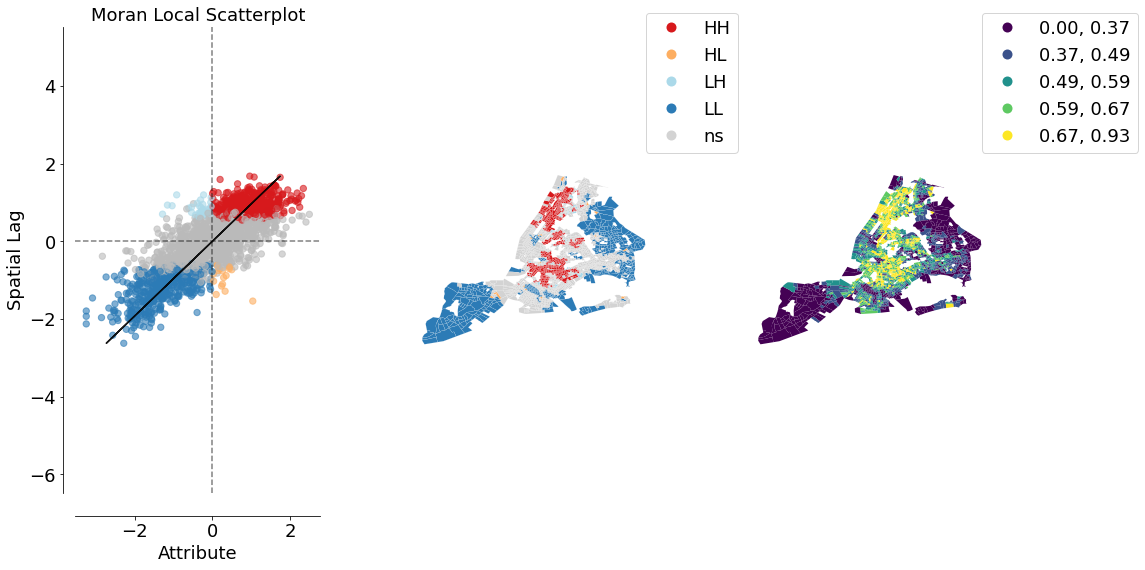

In [51]:
plot_local_autocorrelation(lisa, w_gdf, target_variable, figsize=(16,  8), cmap="viridis")
plt.tight_layout()
plt.savefig("figs/moransi_city_publ.png")

In [52]:
mi = esda.Moran(w_gdf[target_variable], w)
mi.I, mi.p_sim

(0.6902284355923525, 0.001)

(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.69', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.69)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

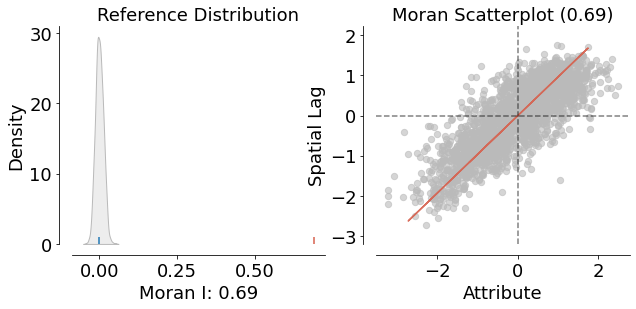

In [53]:
plot_moran(mi)